Saving temp2_Evaluations_allBEFORECRASH.xlsx to temp2_Evaluations_allBEFORECRASH.xlsx


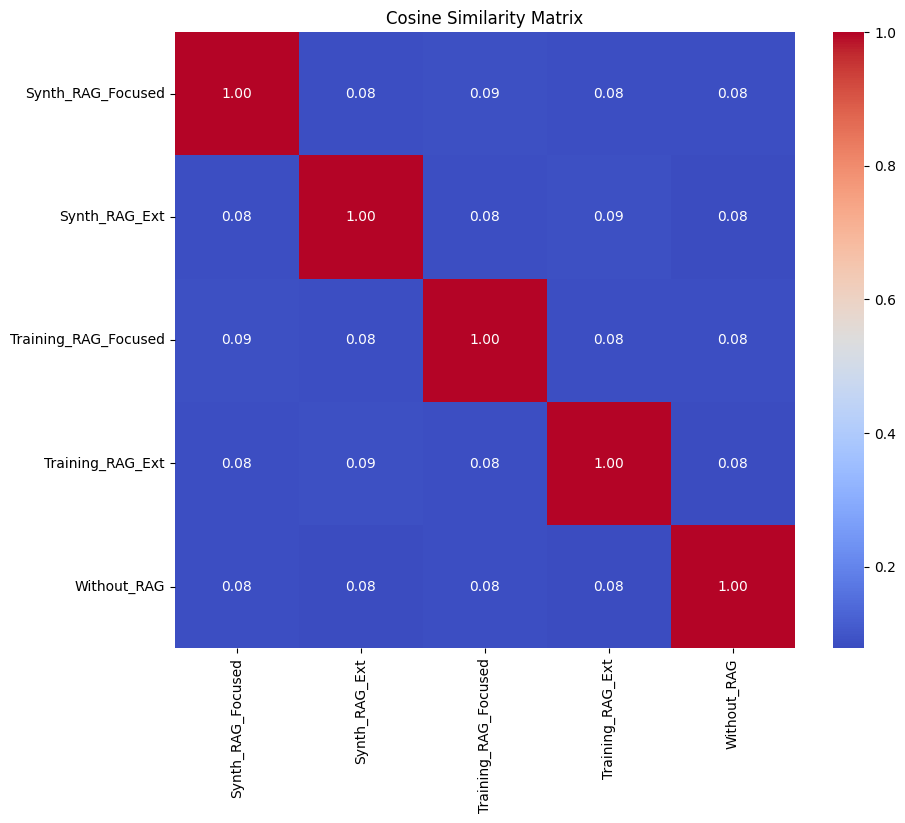

In [14]:

# Install necessary libraries
!pip install pandas numpy scikit-learn seaborn matplotlib openpyxl

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Upload the combined responses data
from google.colab import files
uploaded = files.upload()

# Load the combined responses data
file_name = list(uploaded.keys())[0]
combined_responses_final = pd.ExcelFile(file_name)

# Sheets to consider
sheets_to_consider = [
    'Synth_RAG_Focused',
    'Synth_RAG_Ext',
    'Training_RAG_Focused',
    'Training_RAG_Ext',
    'Without_RAG'
]

# Load the data into a dictionary
combined_data_final = {}
for sheet_name in sheets_to_consider:
    combined_data_final[sheet_name] = combined_responses_final.parse(sheet_name)

# Function to preprocess text data
def preprocess_text(data):
    """
    Ensure all elements in the data are strings.
    """
    return [str(doc) for doc in data]

# Function to calculate the average cosine similarity between different sheets
def calculate_average_cosine_similarity(combined_data):
    sheet_names = list(combined_data.keys())
    num_sheets = len(sheet_names)

    avg_cosine_sim_matrix = np.zeros((num_sheets, num_sheets))

    for i in range(num_sheets):
        for j in range(num_sheets):
            if i == j:
                avg_cosine_sim_matrix[i, j] = 1.0
            else:
                df_i = combined_data[sheet_names[i]]
                df_j = combined_data[sheet_names[j]]

                # Preprocess text data
                responses_i = preprocess_text(df_i['Prompt'].dropna().tolist())
                responses_j = preprocess_text(df_j['Prompt'].dropna().tolist())

                if len(responses_i) == 0 or len(responses_j) == 0:
                    avg_cosine_sim_matrix[i, j] = 0.0
                    continue

                combined_text = responses_i + responses_j
                vectorizer = TfidfVectorizer().fit_transform(combined_text)
                vectors = vectorizer.toarray()

                cos_sim_matrix = cosine_similarity(vectors[:len(responses_i)], vectors[len(responses_i):])
                avg_cosine_sim_matrix[i, j] = np.mean(cos_sim_matrix)

    return avg_cosine_sim_matrix, sheet_names

# Calculate the average cosine similarity matrix
avg_cosine_sim_matrix, sheet_names = calculate_average_cosine_similarity(combined_data_final)

# Plot the cosine similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(avg_cosine_sim_matrix, annot=True, fmt=".2f", xticklabels=sheet_names, yticklabels=sheet_names, cmap='coolwarm')
plt.title('Cosine Similarity Matrix')
plt.show()
